# Are statin prescribing ratios different for dispensing practices?

#### 1. Obtain GP Prescribing data
#### 2. Cut GP Prescribing data for things of interest (statins)
#### 3. Obtain list of dispensing practices
#### 3a. Add codes to list of dispensing practices (name and address only is provided)
#### 4. Combine statin cut and dispensing practice list
#### 5. Compare dispensing vs non-dispensing statin prescribing ratios

In [46]:
import requests
from StringIO import StringIO
from numpy import nan as NA
import pandas as pd
import zipfile
import re
%matplotlib inline
import matplotlib.pyplot as plt
import xlrd
import statsmodels.api as sm
from patsy import dmatrices, dmatrix
import scipy as scipy
import numpy as np

In [2]:
def fetch_prescribing_data():
    url = 'http://datagov.ic.nhs.uk/presentation/2015_01_January/T201501PDPI+BNFT.CSV' #gp prescribing data (Jan 2015)
    r = requests.get(url)
    data = r.content
    df = (pd.read_csv(StringIO(data)))
    df.to_csv('datas/T201501PDPI+BNFT.CSV')

def fetch_dispensary_data():
    url = 'http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/edispensary.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO(r.content))
    df = pd.read_csv(z.open('edispensary.csv'))
    df.to_csv('datas/edispensary.csv')

def fetch_gp_details():
    url = 'http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/epraccur.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO(r.content))
    df = pd.read_csv(z.open('epraccur.csv'))
    df.to_csv('datas/epraccur.csv')

def clean_prescribing_data(df):
    df.columns = [x.strip() for x in df.columns] #gets rid of variable whitespace
    df = df[df['BNF NAME'].str.contains('statin')] #cut for rows with statin in them
    df = df[~df['BNF NAME'].str.contains('Nystatin|Sandostatin|Ecostatin')] #throw away unwanted statins
    df.to_csv('datas/StatinsJan2015.csv') #save the result
    return(df)

def clean_dispensing_practice_addresses(dpad):
    dpad = dpad['Dispensing Practices Address Details'].dropna()
    dpad = dpad.reset_index()
    del dpad['index']
    dpad['Dispensing Practices Address Details'] = dpad['Dispensing Practices Address Details'].str.strip()
    dpad['Dispensing Practices Address Details'] = dpad['Dispensing Practices Address Details'].str.replace('\n', ' ')
    dpad['NAME'] = dpad['Dispensing Practices Address Details'].str.split(',').str[0].str.upper()
    dpad['POSTCODE'] = dpad['Dispensing Practices Address Details'].str.split(',').str[-1].astype(str).str.strip()
    dpad.ix[254,2] = 'BN25 1HH' #one practice lacked a postcode.... we fix this manually
    dpad.ix[254,1] = 'Old School Surgery'
    return(dpad)

def validate_dispensing_postcodes():
    assert(len(dpad[~dpad.Postcode.str.contains(r'[A-Z]{1,2}[0-9R][0-9A-Z]? [0-9][A-Z]{2}')]) == 0) #length of dataframe of postcodes that don't pass regex should be 0 

#nb df = pd.read_csv('http://datagov.ic.nhs.uk/presentation/2015_01_January/T201501PDPI+BNFT.CSV') should also work but seems slower

In [4]:
df = df = pd.read_csv('datas/T201501PDPI+BNFT.CSV') #commented because
df = clean_prescribing_data(df) #commented because need only run once and is slow

In [5]:
#df = fetch_prescribing_data() #commented because requires internet and is slow 
#df = df = pd.read_csv('datas/T201501PDPI+BNFT.CSV') #commented because
#df = clean_prescribing_data(df) #commented because need only run once and is slow
#dispdata = fetch_dispensary_data() #doesn't actually contain dispensing practices
#fetch_gp_details()

df = pd.read_csv('datas/StatinsJan2015.csv') #load cleaned prescribing data cut
gpdetail = pd.read_csv('datas/epraccur.csv') #from http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/epraccur.zip

dpad_formatting_junk = ['Dispensing Practices Address Details', 'Primary Care Trust:', 'Report For:', 'Practice Name and Address', 'January 2015']
dpad = pd.read_excel('datas/Disp Pracs Name and Address 2015-01-31.xls', usecols=[0], na_values=dpad_formatting_junk) #load dispensing practice list

dpad = clean_dispensing_practice_addresses(dpad)

gpdetail = gpdetail.icol([1,2,10,26,15]) #throw away columns we don't care about
gpdetail.columns = ['PRACTICE', 'NAME', 'POSTCODE', 'Prescribing Setting', 'CCG']

dpad = pd.merge(gpdetail, dpad, on=['NAME','POSTCODE']) #merge to add practice codes

df['DP'] = df.PRACTICE.isin(dpad.PRACTICE) #add column DP to identify Dispensing Practices

df['IR'] = df['BNF NAME'].str.contains('Rosuvastatin') #add column for Is Rosuvastatin

In [6]:
df1 = df.groupby(['DP','PRACTICE', 'IR']).ITEMS.sum()


In [7]:
df1.head() #what the datas look like

DP     PRACTICE  IR   
False  A81001    False     256
                 True        8
       A81002    False    2197
                 True       63
       A81003    False     604
Name: ITEMS, dtype: int64

In [8]:
df1 = df1.unstack()
df1 = df1.reset_index()
df1 = df1.fillna(0.0) #applying groupby when there are no items in a category generates NaNs where we would instead prefer 0's


In [9]:
df1.columns = ['DP', 'PRACTICE', 'False_IR', 'True_IR']

In [10]:
df1['Proportion'] = (df1['True_IR'] / (df1['True_IR'] + df1['False_IR']))

In [11]:
df1.head() #what the datas look like

,DP,PRACTICE,False_IR,True_IR,Proportion
0,False,A81001,256,8,0.030303
1,False,A81002,2197,63,0.027876
2,False,A81003,604,2,0.003300
3,False,A81004,787,14,0.017478
4,False,A81005,1112,17,0.015058


In [12]:
df1 = pd.merge(df1, gpdetail, on='PRACTICE')

In [13]:
df1['Prescribing Setting'].unique() #not all our practices are GP practices..

array([ 4,  2,  8, 14,  9,  0,  1, 13, 10, 12, 11, 25,  3])

In [14]:
df1['Prescribing Setting'].value_counts()

4     7865
2      114
9       87
0       55
14      36
1       30
10      16
8       16
13       6
12       6
25       3
3        2
11       1
dtype: int64

In [15]:
df1.groupby('Prescribing Setting').Proportion.mean() #looks like mean proportion varies lots by prescribing setting. nb 10 = hospital

Prescribing Setting
0     0.008713
1     0.038791
2     0.030067
3     0.000000
4     0.027666
8     0.007589
9     0.062790
10    0.107639
11    0.000000
12    0.000000
13    0.000000
14    0.018058
25    0.000000
Name: Proportion, dtype: float64

In [16]:
df1 = df1[df1['Prescribing Setting'] == 4] #throw away ones that aren't GP practices

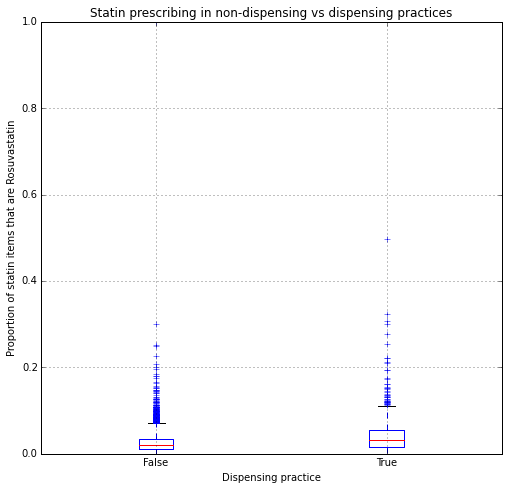

In [17]:
df1[['DP', 'Proportion']].boxplot(by='DP', figsize=(8,8))
plt.title("Statin prescribing in non-dispensing vs dispensing practices")
plt.suptitle("")
#plt.ylim((0,100))
plt.ylabel('Proportion of statin items that are Rosuvastatin')
plt.xlabel('Dispensing practice')

In [18]:
df1[df1['DP'] == False].Proportion.skew()

9.6804834648432934

In [19]:
df1[df1['DP'] == True].Proportion.skew()

3.6919480460793936

In [20]:
df1[df1['DP'] == False].Proportion.var()

0.00065921997382662747

In [21]:
df1[df1['DP'] == True].Proportion.var()

0.001576017180567878

In [22]:
df1[df1['DP'] == False].Proportion.median()

0.01987353206865402

In [23]:
df1[df1['DP'] == True].Proportion.median()

0.03223444953478487

In [24]:
df1[df1['DP'] == False].Proportion.describe()

count    6851.000000
mean        0.025598
std         0.025675
min         0.000000
25%         0.010169
50%         0.019874
75%         0.034544
max         1.000000
Name: Proportion, dtype: float64

In [25]:
df1[df1['DP'] == True].Proportion.describe()

count    1014.000000
mean        0.041637
std         0.039699
min         0.000000
25%         0.016594
50%         0.032234
75%         0.054272
max         0.496923
Name: Proportion, dtype: float64

In [26]:
df1[df1['Proportion'] > 0.5].sort(columns='Proportion', ascending=False).head()

,DP,PRACTICE,False_IR,True_IR,Proportion,NAME,POSTCODE,Prescribing Setting,CCG
1095,False,C83656,0,1,1,UNIVERSITY SURGERY,LN6 7GA,4,04D


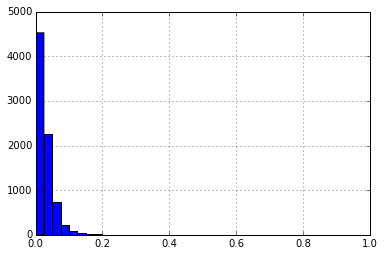

In [27]:
df1.Proportion.hist(bins=40)

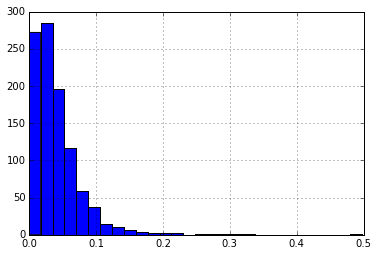

In [28]:
df1[df1['DP'] == True].Proportion.hist(bins=28)

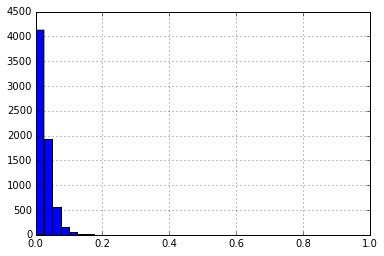

In [29]:
df1[df1['DP'] == False].Proportion.hist(bins=40)

## next steps... add ccg column and try :
## meglm proportionstupid dispensingornot || ccg:, family(binomial) link(logit) in statsmodels

In [30]:
ccg_codes = df1.CCG.unique()
ccg_lookup = zip(list(ccg_codes), range(0,209))
ccg_lookup = dict(ccg_lookup)

In [31]:

df2 = df1[['DP', 'Proportion', 'CCG']]
df2['DP'] = df2['DP'].astype(str).str.replace('False','0').str.replace('True','1')
df2['CCG'] = df2['CCG'].map(lambda x: ccg_lookup.get(x))
df2['DP'] = df2['DP'].astype(int)
df2['CCG'] = df2['CCG'].astype(int)

/home/sam/.virtualenvs/pa-research/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/sam/.virtualenvs/pa-research/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sam/.virtualenvs/pa-research/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [35]:
df2.to_csv('pa_research_for_stata.csv')

In [56]:
def model(df):
           
    y, X = dmatrices('Proportion ~ C(DP) + C(CCG)', data=df, return_type='dataframe') 

    mod = sm.Poisson(y, X) #http://statsmodels.sourceforge.net/devel/endog_exog.html
    
    res = mod.fit(maxiter=100)

    return res



In [61]:
def model2(df):
           
    y, X = dmatrices('Proportion ~ C(DP)', data=df, return_type='dataframe') 

    mod = sm.Poisson(y, X) #http://statsmodels.sourceforge.net/devel/endog_exog.html
    
    res = mod.fit(maxiter=100)

    return res

In [57]:
res = model(df2)

Optimization terminated successfully.
         Current function value: 0.109181
         Iterations 10


In [58]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             Proportion   No. Observations:                 7865
Model:                        Poisson   Df Residuals:                     7655
Method:                           MLE   Df Model:                          209
Date:                Thu, 02 Jul 2015   Pseudo R-squ.:                 0.02658
Time:                        14:47:09   Log-Likelihood:                -858.71
converged:                       True   LL-Null:                       -882.16
                                        LLR p-value:                     1.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -3.9791      1.135     -3.506      0.000        -6.204    -1.755
C(DP)[T.1]        0.4108      0.209      1.961      0.050         0.000     0.821
C(CCG)[T.1]      -0.1114      1.609     -0.069      0.945        -3.264     3.041
C(CCG)[T.2]      -0.0528      1.370     -0.039      0.969        -2.737     2.632
C(CCG)[T.3]       0.1124      1.526      0.074      0.941        -2.879     3.103
C(CCG)[T.4]       0.2849      2.153      0.132      0.895        -3.935     4.505
C(CCG)[T.5]       0.3777      1.534      0.246      0.805        -2.628     3.383
C(CCG)[T.6]      -0.7289      1.824     -0.400      0.689        -4.304     2.846
C(CCG)[T.7]      -0.4278      1.579     -0.271      0.786        -3.523     2.667
C(CCG)[T.8]      -0.7776      2.287     -0.340      0.734        -5.261     3.705
C(CCG)[T.9]      -0.5928      2.178     -0.272      0.785        -4.861     3.676
C(CCG)[T.10]      0.2857      1.430      0.200      0.842        -2.518     3.089
C(CCG)[T.11]      0.2142      1.428      0.150      0.881        -2.584     3.013
C(CCG)[T.12]     -0.0042      1.730     -0.002      0.998        -3.394     3.386
C(CCG)[T.13]      0.4273      1.460      0.293      0.770        -2.434     3.288
C(CCG)[T.14]      0.8044      1.495      0.538      0.590        -2.125     3.734
C(CCG)[T.15]      0.5129      1.453      0.353      0.724        -2.336     3.361
C(CCG)[T.16]      0.5197      1.736      0.299      0.765        -2.883     3.922
C(CCG)[T.17]      0.5725      1.616      0.354      0.723        -2.595     3.740
C(CCG)[T.18]      0.6736      1.662      0.405      0.685        -2.584     3.931
C(CCG)[T.19]      0.0205      1.740      0.012      0.991        -3.389     3.430
C(CCG)[T.20]      0.1393      1.557      0.089      0.929        -2.911     3.190
C(CCG)[T.21]     -0.9282      2.510     -0.370      0.711        -5.847     3.991
C(CCG)[T.22]      0.2080      1.702      0.122      0.903        -3.128     3.544
C(CCG)[T.23]      0.9403      1.409      0.668      0.504        -1.820     3.701
C(CCG)[T.24]      0.7405      1.385      0.535      0.593        -1.974     3.455
C(CCG)[T.25]      0.4710      1.472      0.320      0.749        -2.414     3.356
C(CCG)[T.26]      0.2700      1.485      0.182      0.856        -2.640     3.180
C(CCG)[T.27]      0.7160      1.479      0.484      0.628        -2.184     3.616
C(CCG)[T.28]      0.4536      1.451      0.313      0.755        -2.391     3.298
C(CCG)[T.29]     -0.3161      1.749     -0.181      0.857        -3.743     3.111
C(CCG)[T.30]     -0.8930      1.861     -0.480      0.631        -4.541     2.755
C(CCG)[T.31]     -0.6493      2.772     -0.234      0.815        -6.083     4.784
C(CCG)[T.32]     -0.6995      3.145     -0.222      0.824        -6.864     5.465
C(CCG)[T.33]      0.3653      1.481      0.247      0.805        -2.537     3.268
C(CCG)[T.34]      0.0980      1.476      0.066      0.947        -2.795     2.991
C(CCG)[T.35]     -0.2097      1.534     -0.

In [62]:
res.params

Intercept       -3.979077
C(DP)[T.1]       0.410769
C(CCG)[T.1]     -0.111390
C(CCG)[T.2]     -0.052832
C(CCG)[T.3]      0.112426
C(CCG)[T.4]      0.284940
C(CCG)[T.5]      0.377666
C(CCG)[T.6]     -0.728896
C(CCG)[T.7]     -0.427804
C(CCG)[T.8]     -0.777628
C(CCG)[T.9]     -0.592840
C(CCG)[T.10]     0.285675
C(CCG)[T.11]     0.214190
C(CCG)[T.12]    -0.004219
C(CCG)[T.13]     0.427316
C(CCG)[T.14]     0.804398
C(CCG)[T.15]     0.512880
C(CCG)[T.16]     0.519723
C(CCG)[T.17]     0.572528
C(CCG)[T.18]     0.673609
C(CCG)[T.19]     0.020467
C(CCG)[T.20]     0.139278
C(CCG)[T.21]    -0.928172
C(CCG)[T.22]     0.208026
C(CCG)[T.23]     0.940342
C(CCG)[T.24]     0.740523
C(CCG)[T.25]     0.470965
C(CCG)[T.26]     0.270046
C(CCG)[T.27]     0.716047
C(CCG)[T.28]     0.453588
                   ...   
C(CCG)[T.179]    0.588847
C(CCG)[T.180]   -0.289249
C(CCG)[T.181]   -0.634746
C(CCG)[T.182]   -0.265705
C(CCG)[T.183]    0.172236
C(CCG)[T.184]    0.320217
C(CCG)[T.185]    0.004534
C(CCG)[T.186

In [63]:
np.exp(res.params) 

Intercept        0.018703
C(DP)[T.1]       1.507977
C(CCG)[T.1]      0.894590
C(CCG)[T.2]      0.948540
C(CCG)[T.3]      1.118989
C(CCG)[T.4]      1.329682
C(CCG)[T.5]      1.458876
C(CCG)[T.6]      0.482441
C(CCG)[T.7]      0.651939
C(CCG)[T.8]      0.459495
C(CCG)[T.9]      0.552755
C(CCG)[T.10]     1.330660
C(CCG)[T.11]     1.238858
C(CCG)[T.12]     0.995790
C(CCG)[T.13]     1.533137
C(CCG)[T.14]     2.235350
C(CCG)[T.15]     1.670095
C(CCG)[T.16]     1.681561
C(CCG)[T.17]     1.772743
C(CCG)[T.18]     1.961304
C(CCG)[T.19]     1.020678
C(CCG)[T.20]     1.149443
C(CCG)[T.21]     0.395275
C(CCG)[T.22]     1.231245
C(CCG)[T.23]     2.560858
C(CCG)[T.24]     2.097033
C(CCG)[T.25]     1.601540
C(CCG)[T.26]     1.310025
C(CCG)[T.27]     2.046328
C(CCG)[T.28]     1.573949
                   ...   
C(CCG)[T.179]    1.801909
C(CCG)[T.180]    0.748826
C(CCG)[T.181]    0.530070
C(CCG)[T.182]    0.766665
C(CCG)[T.183]    1.187958
C(CCG)[T.184]    1.377427
C(CCG)[T.185]    1.004545
C(CCG)[T.186